In [ ]:
rm -rf /content/Data

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle competitions download -c tgs-salt-identification-challenge --force

 98% 434M/445M [00:04<00:00, 114MB/s]
100% 445M/445M [00:04<00:00, 98.1MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/tgs-salt-identification-challenge.zip')
zip_ref.extractall('/content/Data')
zip_ref.close()

In [ ]:
import os

zip_files = [
    '/content/Data/train.zip',
    '/content/Data/test.zip',
]

for zip_file in zip_files:
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        if 'train.zip' in zip_file:
            extract_path = '/content/Data/train'
            os.makedirs(extract_path, exist_ok=True)
            zip_ref.extractall(extract_path)
        elif 'test.zip' in zip_file:
            extract_path = '/content/Data/test'
            os.makedirs(extract_path, exist_ok=True)
            zip_ref.extractall(extract_path)
        else:
            zip_ref.extractall('/content/Data')

In [ ]:
## Imports
import os
import sys
import random

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers


## Seeding
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed

In [ ]:
dataset_path = "/content/Data/"
train_path = os.path.join(dataset_path, "train/")

In [ ]:
class DataGen(keras.utils.Sequence):
    def __init__(self, ids, path, batch_size=8, image_size=128):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()

    def __load__(self, id_name):
        ## Path
        image_path = os.path.join(self.path, "images", id_name) + ".png"
        mask_path = os.path.join(self.path, "masks", id_name) + ".png"

        ## Reading Image
        image = cv2.imread(image_path)
        image = cv2.resize(image, (self.image_size, self.image_size))

        ##Reading Mask
        mask = cv2.imread(mask_path, 0)
        mask = cv2.resize(mask, (self.image_size, self.image_size))
        mask = np.expand_dims(mask, axis=-1)

        ## Normalizaing
        image = image/255.0
        mask = mask/255.0

        return image, mask

    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size

        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]

        image = []
        mask  = []

        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask)

        image = np.array(image)
        mask  = np.array(mask)

        return image, mask

    def on_epoch_end(self):
        pass

    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

In [ ]:
train_csv = pd.read_csv(train_path + "train.csv")
train_ids = train_csv["id"].values

image_size = 128
batch_size = 16

val_data_size = 200

valid_ids = train_ids[:val_data_size]
train_ids = train_ids[val_data_size:]

In [ ]:
gen = DataGen(train_ids, train_path, batch_size=batch_size, image_size=image_size)
x, y = gen.__getitem__(0)
print(x.shape, y.shape)

(16, 128, 128, 3) (16, 128, 128, 1)


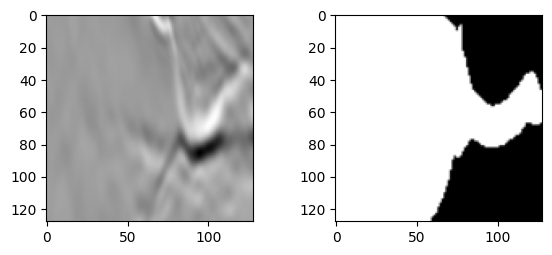

In [ ]:
r = random.randint(0, len(x)-1)

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x[r])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(y[r]*255, (image_size, image_size)), cmap="gray")

In [ ]:
def bn_act(x, act=True):
    x = keras.layers.BatchNormalization()(x)
    if act == True:
        x = keras.layers.Activation("relu")(x)
    return x

def conv_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = bn_act(x)
    conv = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(conv)
    return conv

def stem(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    conv = conv_block(conv, filters, kernel_size=kernel_size, padding=padding, strides=strides)

    shortcut = keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)

    output = keras.layers.Add()([conv, shortcut])
    return output

def residual_block_with_dropout(x, filters, kernel_size=(3, 3), padding="same", strides=1, dropout_rate=0.5):
    res = conv_block(x, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    res = keras.layers.Dropout(dropout_rate)(res)  # Add dropout here
    res = conv_block(res, filters, kernel_size=kernel_size, padding=padding, strides=1)

    shortcut = keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)

    output = keras.layers.Add()([shortcut, res])
    return output

def conv_block_with_regularization(x, filters, kernel_size=(3, 3), padding="same", strides=1, kernel_regularizer=regularizers.l2(0.01)):
    conv = bn_act(x)
    conv = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, kernel_regularizer=kernel_regularizer)(conv)
    return conv

def upsample_concat_block(x, xskip):
    u = keras.layers.UpSampling2D((2, 2))(x)
    c = keras.layers.Concatenate()([u, xskip])
    return c

In [ ]:
def ResUNet(dropout_rate=0.5, kernel_regularizer=regularizers.l2(0.01)):
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, 3))

    ## Encoder
    e0 = inputs
    e1 = stem(e0, f[0])
    e2 = residual_block_with_dropout(e1, f[1], strides=2, dropout_rate=dropout_rate)
    e3 = residual_block_with_dropout(e2, f[2], strides=2, dropout_rate=dropout_rate)
    e4 = residual_block_with_dropout(e3, f[3], strides=2, dropout_rate=dropout_rate)
    e5 = residual_block_with_dropout(e4, f[4], strides=2, dropout_rate=dropout_rate)

    ## Bridge
    b0 = conv_block_with_regularization(e5, f[4], strides=1, kernel_regularizer=kernel_regularizer)
    b1 = conv_block_with_regularization(b0, f[4], strides=1, kernel_regularizer=kernel_regularizer)

    ## Decoder
    u1 = upsample_concat_block(b1, e4)
    d1 = residual_block_with_dropout(u1, f[4], dropout_rate=dropout_rate)

    u2 = upsample_concat_block(d1, e3)
    d2 = residual_block_with_dropout(u2, f[3], dropout_rate=dropout_rate)

    u3 = upsample_concat_block(d2, e2)
    d3 = residual_block_with_dropout(u3, f[2], dropout_rate=dropout_rate)

    u4 = upsample_concat_block(d3, e1)
    d4 = residual_block_with_dropout(u4, f[1], dropout_rate=dropout_rate)

    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(d4)
    model = keras.models.Model(inputs, outputs)
    return model

In [ ]:
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = tf.compat.v1.layers.flatten(y_true)
    y_pred_f = tf.compat.v1.layers.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [ ]:
model = ResUNet()
adam = keras.optimizers.Adam()
model.compile(optimizer=adam, loss=dice_coef_loss, metrics=[dice_coef])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 16)         448       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 16)         64        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 128, 128, 16)         0         ['batch_normalization[0][0

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size)
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size)

train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size

epochs = 100

model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps,
                    epochs=epochs)

Epoch 1/100


<ipython-input-17-606b4c2b7a19>:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps,
/usr/local/lib/python3.10/dist-packages/tensorflow/python/autograph/impl/api.py:460: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
  return f(*args)
/usr/local/lib/python3.10/dist-packages/keras/src/legacy_tf_layers/base.py:623: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  self.updates, tf.compat.v1.GraphKeys.UPDATE_OPS


237/237 [==============================] - 1206s 5s/step - loss: 0.8335 - dice_coef: 0.6040 - val_loss: 0.6598 - val_dice_coef: 0.3922
Epoch 2/100
237/237 [==============================] - 855s 4s/step - loss: 0.3932 - dice_coef: 0.6485 - val_loss: 0.4675 - val_dice_coef: 0.5552
Epoch 3/100
237/237 [==============================] - 888s 4s/step - loss: 0.3811 - dice_coef: 0.6629 - val_loss: 0.4054 - val_dice_coef: 0.6283
Epoch 4/100
158/237 [===================>..........] - ETA: 5:11 - loss: 0.3435 - dice_coef: 0.6890

In [ ]:
model.save("ResUNet.h5")


      Ground Truth            Predicted Value
1/1 [==============================] - 0s 34ms/step


<ipython-input-56-6cb5e070ff26>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


1/1 [==============================] - 0s 32ms/step


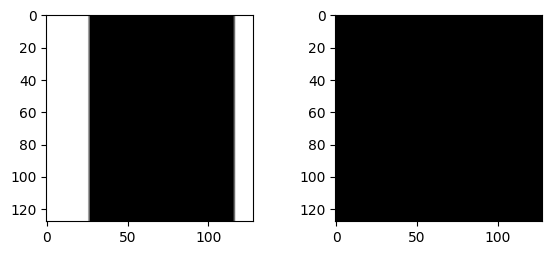

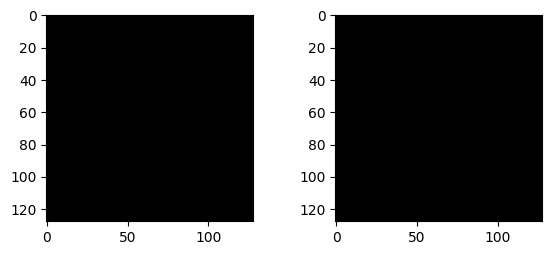

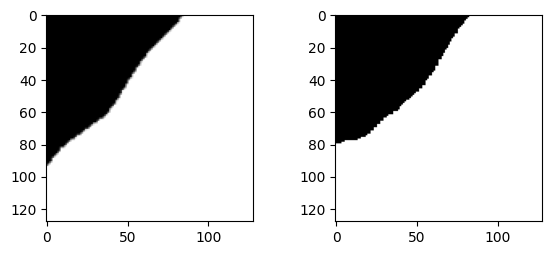

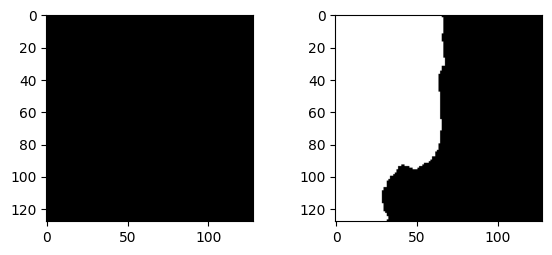

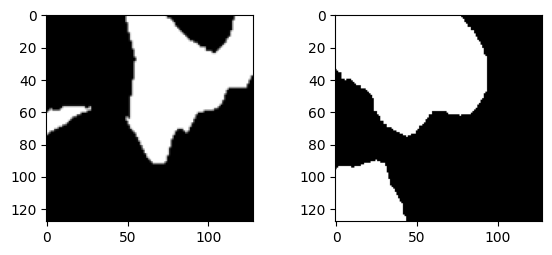

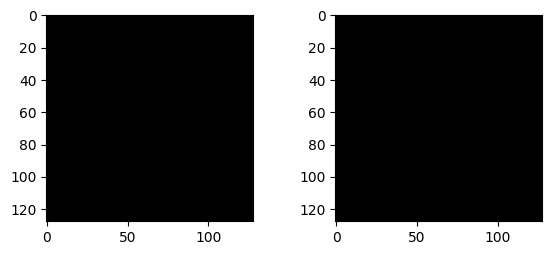

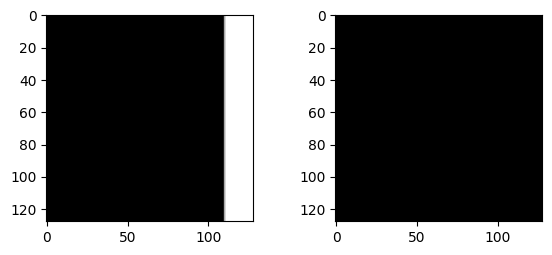

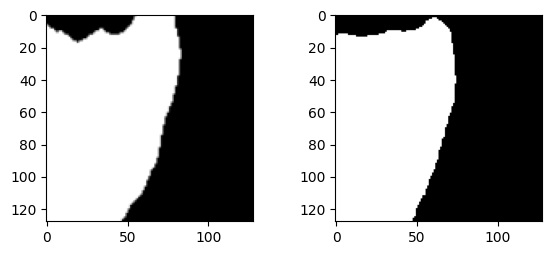

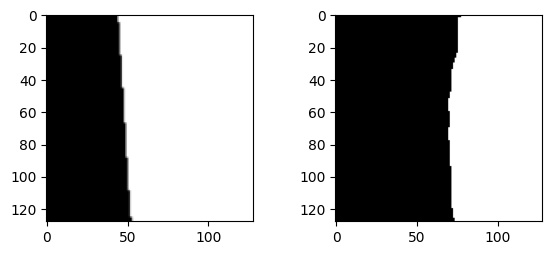

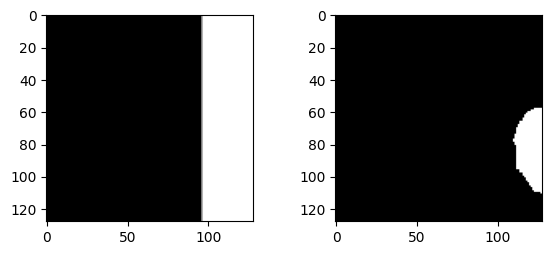

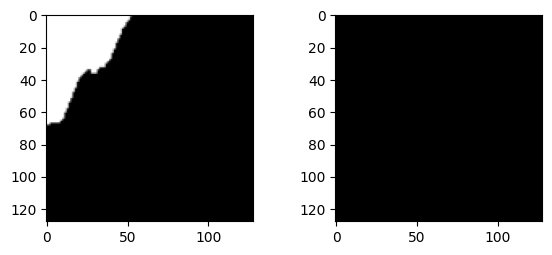

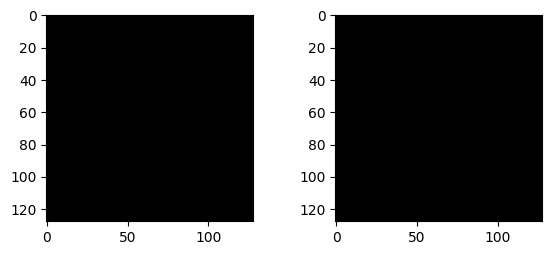

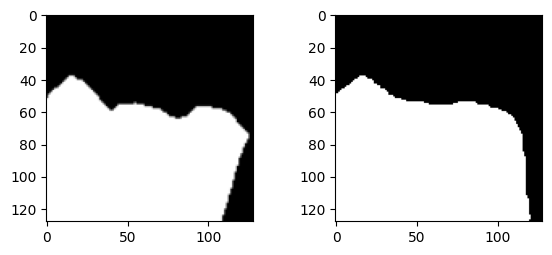

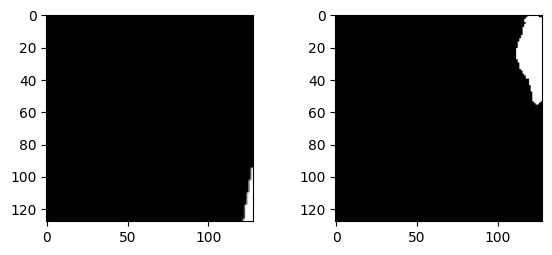

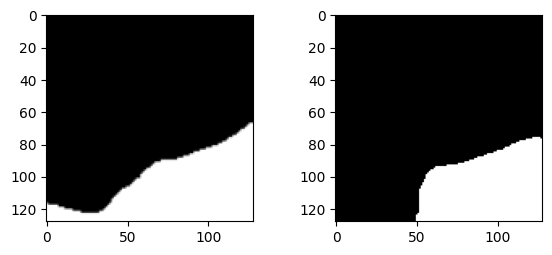

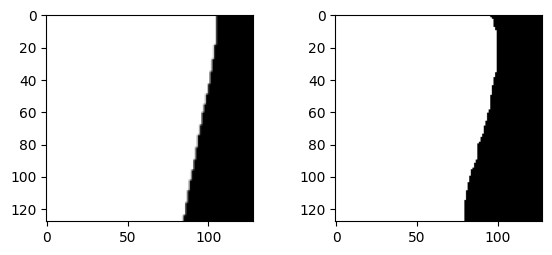

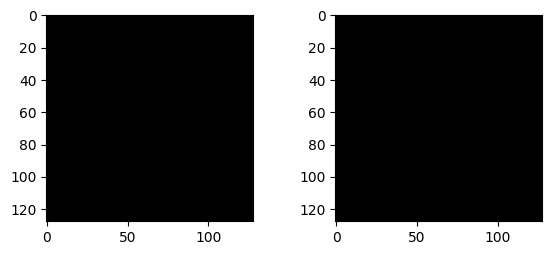

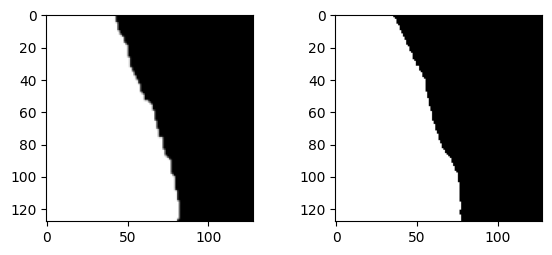

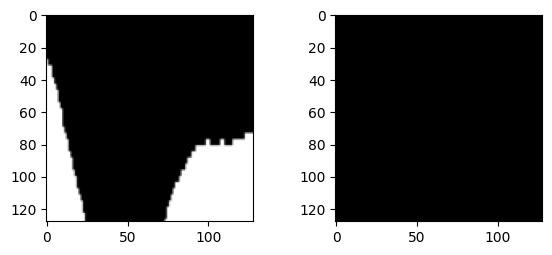

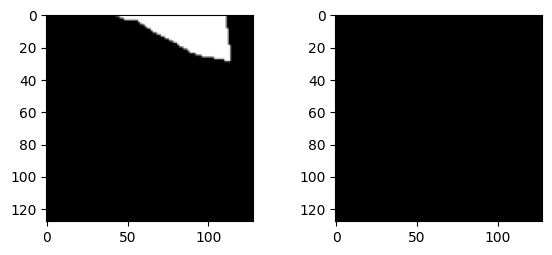

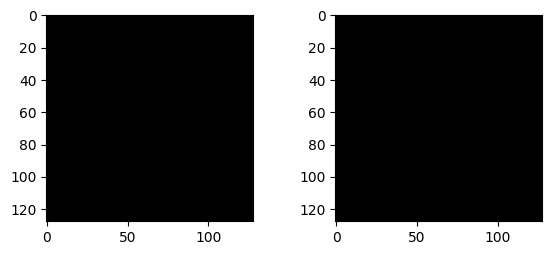

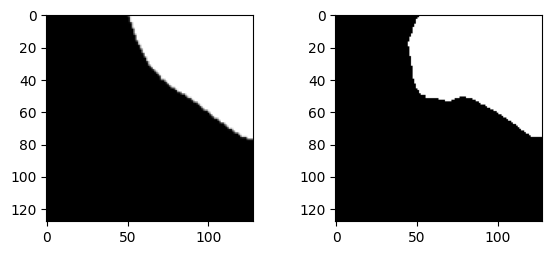

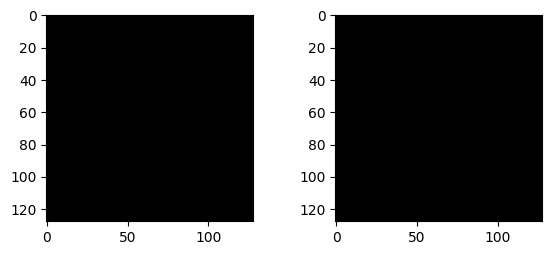

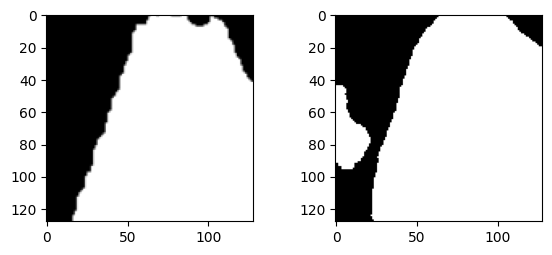

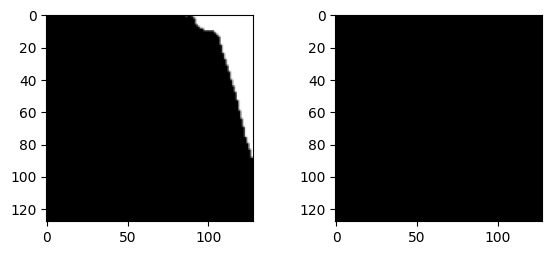

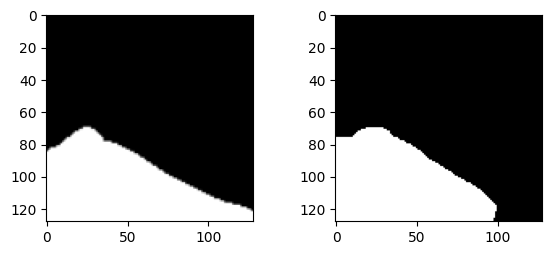

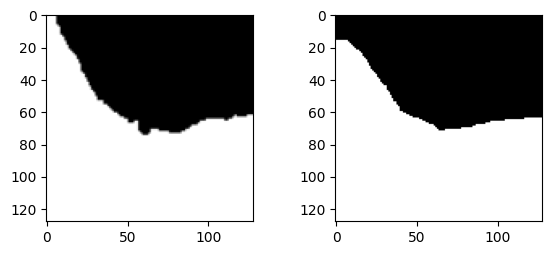

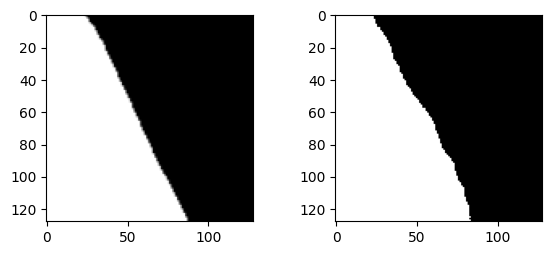

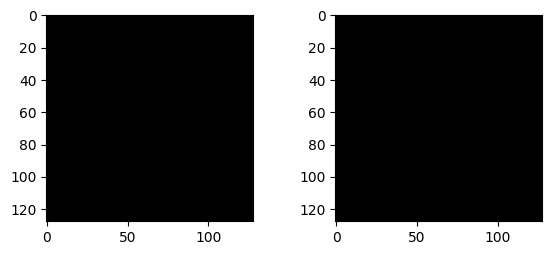

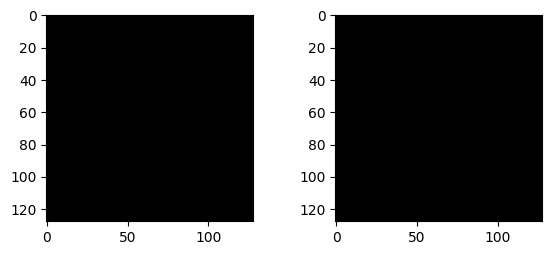

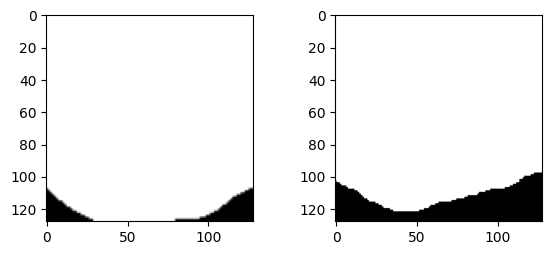

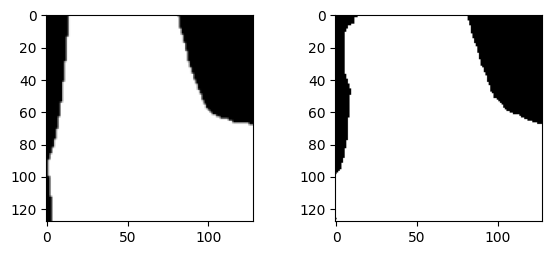

In [ ]:
print("\n      Ground Truth            Predicted Value")

for i in range(1, 5, 1):
    ## Dataset for prediction
    x, y = valid_gen.__getitem__(i)
    result = model.predict(x)
    result = result > 0.4

    for i in range(len(result)):
        fig = plt.figure()
        fig.subplots_adjust(hspace=0.4, wspace=0.4)

        ax = fig.add_subplot(1, 2, 1)
        ax.imshow(np.reshape(y[i]*255, (image_size, image_size)), cmap="gray")

        ax = fig.add_subplot(1, 2, 2)
        ax.imshow(np.reshape(result[i]*255, (image_size, image_size)), cmap="gray")

In [ ]:
import tensorflow as tf
from tensorflow import keras

# Check versions
print(tf.__version__)

2.14.0


In [ ]:
import tensorflow as tf
from tensorflow import keras

# Assuming the model is saved in the specified path
model_path = "/content/ResUNet.h5"
loaded_model = keras.models.load_model(model_path, custom_objects={'dice_coef_loss': dice_coef_loss, 'dice_coef': dice_coef})

In [ ]:
# Assuming you want the user to input the path to an image
user_input_path = input("Enter the path to the image you want to predict: ")

# Use a similar preprocessing function as in your DataGen class
def preprocess_input_image(image_path, image_size):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (image_size, image_size))
    image = image / 255.0  # Normalize the image
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

user_input_image = preprocess_input_image(user_input_path, image_size)

# Assuming the model is loaded successfully
predictions = loaded_model.predict(user_input_image)

Enter the path to the image you want to predict: /content/Data/test/images/010082e36a.png
1/1 [==============================] - 1s 794ms/step


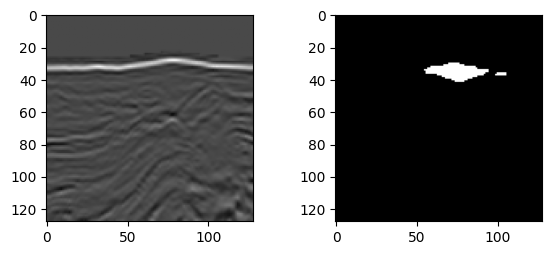

In [ ]:
# Assuming you want to visualize the original image, ground truth, and predicted mask
result = predictions[0] > 0.4

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(user_input_image[0])

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result*255, (image_size, image_size)), cmap="gray")

plt.show()


In [ ]:
import tensorflow as tf
from tensorflow import keras

# Assuming you have a validation generator (similar to the training generator)
# and you want to evaluate the metrics on the validation dataset
val_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size)

# Evaluate the model on the validation dataset
evaluation = loaded_model.evaluate(val_gen)

# The evaluation result will include the dice coefficient and dice coefficient loss
dice_coefficient = evaluation[1]
dice_coefficient_loss = evaluation[0]

# Print or use these values as needed
print("Dice Coefficient:", dice_coefficient)
print("Dice Coefficient Loss:", dice_coefficient_loss)


13/13 [==============================] - 2s 42ms/step - loss: 0.2715 - dice_coef: 0.7497
Dice Coefficient: 0.7496583461761475
Dice Coefficient Loss: 0.27148890495300293


In [ ]:
%cp -r /content/Data /content/drive/MyDrive/ResUNET